# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [137]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
#     hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False)
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['punc_count2'] = toxic_data['comment_text'].str.count("\!!")
    toxic_data['punc_count3'] = toxic_data['comment_text'].str.count("\!!!")
    toxic_data['punc_count4'] = toxic_data['comment_text'].str.count("\!!!!")
    toxic_data['punc_count5'] = toxic_data['comment_text'].str.count("\!!!!!")
    toxic_data['punc_count6'] = toxic_data['comment_text'].str.count("\!!!!!!")
    toxic_data['punc_count7'] = toxic_data['comment_text'].str.count("\!!!!!!!")
    toxic_data['punc_count8'] = toxic_data['comment_text'].str.count("\?")
    toxic_data['punc_count9'] = toxic_data['comment_text'].str.count("\??")
    toxic_data['punc_count10'] = toxic_data['comment_text'].str.count("\???")
        
    X_quant_features = toxic_data[["word_count", "punc_count","punc_count2","punc_count3","punc_count4","punc_count5","punc_count6","punc_count7","punc_count8","punc_count9","punc_count10"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [138]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../final_data/toxiccomments_train.csv', my_random_seed=33)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

In [62]:
# MODEL: ordinary least squares

# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

In [139]:
# MODEL: SVM, linear

from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13023, 'Neg': 114633, 'TP': 12961, 'TN': 114551, 'FP': 82, 'FN': 62, 'Accuracy': 0.9988719684151156, 'Precision': 0.9937131028137698, 'Recall': 0.9952391921984182, 'desc': 'svm_train'}


In [143]:
# MODEL: logistic regression

from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13023, 'Neg': 114633, 'TP': 12973, 'TN': 114599, 'FP': 34, 'FN': 50, 'Accuracy': 0.9993419815754842, 'Precision': 0.9973860229107404, 'Recall': 0.9961606388696921, 'desc': 'lgs_train'}


In [144]:
# MODEL: Naive Bayes

from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13023, 'Neg': 114633, 'TP': 12788, 'TN': 105633, 'FP': 9000, 'FN': 235, 'Accuracy': 0.9276571410666166, 'Precision': 0.5869285845419497, 'Recall': 0.9819550026875528, 'desc': 'nbs_train'}


In [145]:
# MODEL: Perceptron

from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13023, 'Neg': 114633, 'TP': 12905, 'TN': 114550, 'FP': 83, 'FN': 118, 'Accuracy': 0.9984254559127655, 'Precision': 0.9936094856790884, 'Recall': 0.9909391077324733, 'desc': 'prc_train'}


In [146]:
# MODEL: Ridge Regression Classifier

from sklearn import linear_model

# alphas = [0.1, 0.5, 1.0, 5.0, 20]
alphas = [20]

for alpha in alphas:
    rdg = linear_model.RidgeClassifier(alpha)
    rdg.fit(X_train, y_train)

    rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
    rdg_performance_train.compute_measures()
    print(rdg_performance_train.performance_measures)

{'Pos': 13023, 'Neg': 114633, 'TP': 10896, 'TN': 114514, 'FP': 119, 'FN': 2127, 'Accuracy': 0.9824058406968729, 'Precision': 0.9891965501588743, 'Recall': 0.8366735775167012, 'desc': 'rdg_train'}


In [147]:
# MODEL: Random Forest Classifier

# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth=2, random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

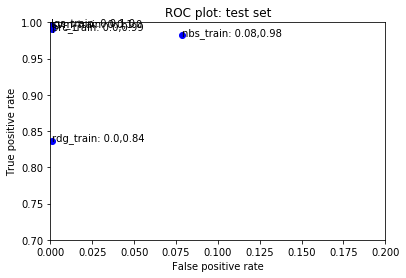

In [148]:
# ROC plot to compare performance of various models and fits

# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
fits = [ svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc +': '+str(round(fit.performance_measures['FP'] / fit.performance_measures['Neg']*100)/100) +','+ str(round(fit.performance_measures['TP'] / fit.performance_measures['Pos']*100)/100) )
plt.axis([0, .2, 0.7, 1])
# plt.ylim(0.5, 1)
# plt.xlim(0.5,1)
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [150]:
# ols_predictions = ols.predict(X_train)
# svm_predictions = svm.predict(X_train)
# lgs_predictions = lgs.predict(X_train)
the_preds = nbs.predict(X_train)
# prc_predictions = prc.predict(X_train)
# rdg_predictions = rdg.predict(X_train)



In [151]:
# let's look at some false positives:

# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(the_preds)):
    if (the_preds[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
20
This message is regarding the article BMX XXX. Please stop.  If you continue to vandalize pages, you will be blocked from editing Wikipedia.   (|☎)
* * * * * * * * * 
123
is anyone there? HELLO? MOM??????
* * * * * * * * * 
142
"
 Hey, thanks! talk "
* * * * * * * * * 
149
Caitlin Carter  

Caitlin Carter is the best girlfriend a guy could ask for and her boy friend hunter knows this. And he loves her very very much!  They will always be together no matter what and she makes him feel like a king!
* * * * * * * * * 
267
"This article should more properly be called ""Blink element type""."
* * * * * * * * * 
374
You make the page worthless.
* * * * * * * * * 
1110
Well he said it himself. I shall paraphrase: thanks to feminism, unattractive women now have easier access to mainstream society. What about that statement is not feminist?
* * * * * * * * * 
1144
"
Tried in the ""New Admin School"" page, very cool and fast indeed, thanks a bunch!   "
* * * * * *

18151
(p.s: don't worry, I'm not a frustrated 12 yr old.)
* * * * * * * * * 
18243
Time for another blocked IP address. Lets see how many I can do tonight.
* * * * * * * * * 
18351
Just to say I don't like either the word terrorist (such an abused term it's ridiculous) or the word extremist (tells you precisely nothing).
* * * * * * * * * 
18464
Mel, I think you get the picture now.   David accuses me of vandalism over and over again, but refuses to show one instance of it....because there are none.  Personal attacks at their finest.
* * * * * * * * * 
19385
Is it customary to delete stuff without explanation on the talk page? Someone deleted my citation without any notice. 24.28.70.129
* * * * * * * * * 
19539
"

 hello 

when I try to add ""American"" to the movie , Darkwarriorblake revert it, the movie is from United States, so need to have the ""American"" Thanks."
* * * * * * * * * 
20279
Hi World! Hows it going
* * * * * * * * * 
20558
I don't give

I don't give, so shove it!
* *

47049
Jesus Christ, some of those were quite amusing...
* * * * * * * * * 
47207
Web 

Is this her own website? 113.22.84.65
* * * * * * * * * 
47327
I didn't accuse anyone of vandalism nor I am disagreeing with any administrative action you've taken. If you try to actually read my comments rather than read smth into them that will be obvious to you as well. And please excuse me, but I will not be answering your further comments (if any) as you not trying to understand what I'm saying.
* * * * * * * * * 
47961
So you really don't see anything AT ALL wrong in doing something that a lot of people here don't want? That's an incredibly selfish position to take. Maybe we're losing something in the language here between cultures, and I really don't think you're as selfish as the words you're using suggest, but that's the way it reads to me.
* * * * * * * * * 
48587
Oy vey 

Would you consider the redirect I suggested (after you edited) on Wikipedia:Articles for deletion/Oy vey   | Talk
* * *

56270
What conclusion did you reach about the antisemitic/living person bio
on Madoff?
* * * * * * * * * 
56295
They have once more reverted a good edit  86.13.182.103
* * * * * * * * * 
56694
dung. Libra, aren't you?
* * * * * * * * * 
56753
"

Why are you still here then - get a life. Stop being all ""Ooooo, look at me, I am such a big important person since I can control whats on a totally minor topic on an insignificant corner of the wikipedia website"""
* * * * * * * * * 
56956
Read the first sentence of Wikipedia:Huggle
* * * * * * * * * 
57216
The statement above, from Jayron32 is not true - I have never been banned. Could he please cite the diff that this decision is based upon?
* * * * * * * * * 
57426
Gale, you're living proof why wikipedia should NEVER be trusted as fact. I mean, telling someone to blindly believe whatever's said instead of verifying? You need to take a walk in traffic for saying that!

99.149.119.168
* * * * * * * * * 
57835
and are lies (which is why i rem

78294
"
Stop vandalizing the fricken page, then we'll listen to what you have to say. @ "
* * * * * * * * * 
78695
HI 

you are imature and a real time KNOB
* * * * * * * * * 
79113
Whoever wrote this, dont worry this kid used to be a big-time loser and kinda changed over the years.
* * * * * * * * * 
79562
on the spot. Actually, I am just going to go ahead and report you now as I really don't have the patience for the games
* * * * * * * * * 
79663
The link in question is RELEVANT and has been on the site for one year previously, its the most popular fan site relating to Steven Tyler on the net, please stop abusing your position and let the people decide, just google steven tyler and you will see sexysteventyler.com is position 3 plus its less commercial site than imdb and the other sites you have listed. Good Luck
* * * * * * * * * 
79676
she did 76.122.79.82
* * * * * * * * * 
79721
And if you don't, well let's just say this campaign isn't a 'vote or die' for nothing

Did I mention 

97608
, and I'm sorry for the damage I caused.Okay I was just angry about something.
* * * * * * * * * 
97664
Do ya! 
Do ya like spongebob? (  )
* * * * * * * * * 
97904
Preceding unsigned comment added by 166.216.165.20
* * * * * * * * * 
98001
i have no life i edit wikipedia
* * * * * * * * * 
98120
Very Sorry 

I am sorry if this IP address has made any unconstructive edits, or vandalism, but it is a public computer and many people use it. Just to say, if you see this IP make any other edits, know that it isn`t one person. Of course, I will respect the editing guidelines if ever I do edit.
Have a nice day! 207.164.143.162
* * * * * * * * * 
98184
What you are saying about
* * * * * * * * * 
98582
Please remove the block time from indefinete. Please put it to however long you want, as long as it's not indefinite. I will stop editing in a vandalizing form
* * * * * * * * * 
98844
. No BenBen, I have twelve. It says so in the wikipedia constitution.
* * * * * * * * * 
99068
, or even t

116340
"

And what's the problem with ""neo""?  ·:·   ·:· "
* * * * * * * * * 
116620
Look at http://www.DerHexer.Homo.com !!!! 62.158.114.87
* * * * * * * * * 
116779
"
Per WP:TWITTER it says it right there, as I pointed out in my original edit summary when I reverted your edit Jack, sorry, nothing I can do buddy.  (mailbox) "
* * * * * * * * * 
117407
Merge Harry Kipper into this 

I don't think there is enough about Harry Kipper to justify a separate page.
* * * * * * * * * 
117589
Thanks, but I think Mike's wife left him or something because he won't let me edit anything.
* * * * * * * * * 
118315
Please Stop

Stay in your corner, and I'll stay in mine, OK?
* * * * * * * * * 
118723
yo what video do u have. E
* * * * * * * * * 
118744
I WONDER IF.... 

As per your comment that a pic of Mohammed would 'offend' Muslims, I wonder if you'd extend the same courtesy to Christians or Jews? I doubt it somehow, Atheists tend to be totally one sided in their love of Islam and hatred of Chris

In [104]:
# false positives

print("Examples of false negatives:")

import random, time

for i in range(0, len(the_preds)):
    if (the_preds[i] == 0):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
#             if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

Examples of false negatives:
346
stupid bots deleting pics

I would like to ask a HUMAN to review the entry, and possibly add photos from the links I have provided. I cannot figure out how to do it myself.

Also, someone should either reprogram or shut down this BOT.

April 2008
 Welcome to Wikipedia. Although everyone is welcome to contribute constructively to the encyclopedia, one or more of the external links you added  do not comply with our guidelines for external links and have been removed. Wikipedia is not a collection of links; nor should it be used for advertising or promotion. Since Wikipedia uses nofollow tags, external links do not alter search engine rankings. If you feel the link should be added to the article, please discuss it on the  before reinserting it. Please take a look at the welcome page to learn more about contributing to this encyclopedia. 

Your edit here was reverted by an automated bot that attempts to remove unwanted links and spam from Wikipedia. If you 

9617
This guys is a joke as an admin. You will have no luck with him. He really should stop being an admin as he does the wikipedia community an injustice by staying in his position.
* * * * * * * * * 
10159
What an amazing coincidence the admin who deals with this complaint should also have military history listed as their areas of expertise. Nothing untoward going on here then.

It's c***s like you who ensure the information in wiki remains unreliable.
* * * * * * * * * 
10164
Yes it is. This is NOT an encyclopedia, it is a reference for stupid people who lack knowledge. Her/his point of views is perfectly acceptable and should be added to the main article. Thanks
* * * * * * * * * 
12776
So if someone stands up to your bullying, their work is a piece of shit. Like I said: appalling. Nevertheless, I don't mind telling you that I have tried in the past, while doing the primary work on the article, to use block quotes for precisely the purpose you suggest (I am tempted to say great min

21393
I disagree.  I think this is worthy of a seperate article.  What is with you people and merging or deleting shit anyway?
* * * * * * * * * 
22078
"
 Uh,  I didn't start by being uncivil to you,  nor was my comment on the policy talk page uncivil unlike yours.  Should I report you for a personal attack?!? P
My contention was merely than ""uncivil"" replies were appropriate when policies have been violated,  or individuals are in fact being uncivil.  But:  since your comments seem to indicate that you are an ass,  well,  meh you then.    "
* * * * * * * * * 
22111
That rule is an electric fence.  Even though the page was protected, the letter of the rule says he should be blocked.  His ass has long had a block coming anyway.
* * * * * * * * * 
22619
"

Thank you for experimenting with the page Fuck on Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn mo

42230
"

Fuck off you stupid fucking retard cunt.

{| style=""border: 1px solid gray; background-color: #fdffe7;""
|rowspan=""2"" valign=""middle"" | 
|rowspan=""2"" |
|style=""font-size: x-large; padding: 0; vertical-align: middle; height: 1.1em;"" | The stupid fucking retard barnstar for people who collect sad awards like this
|-
|style=""vertical-align: middle; border-top: 1px solid gray;"" | You are a fucking retard"
* * * * * * * * * 
42317
Teens will always get bored with Shakespeare. And they'll also get bored with Rebecca, Tom Sawyer, A Separate Peace, and almost every other fucking classical novel that exists in the English-speaking world!!! What classical book DOES a teen like?
* * * * * * * * * 
43932
"
""Word count is not a measure of encyclopedic value"". You're not attending a special school are you? How dumb do you have to be to be able to make these sorts of claims? What the fuck are those 20,000 words detailing, if it's largely things of unencyclopedic value? Why don't

56858
You need to end this now, cold turkey.
* * * * * * * * * 
56988
Quick question 

Why do you suck so much, and what actions do you take to ensure your low quality in every respect?
* * * * * * * * * 
57631
I AM ADDING REFERENCES AND AM REMOVING THE TAGS AS I GO. SO STICK YOUR LAST WARNING!!!
* * * * * * * * * 
57869
well, you know, fuck your idea of 'notability', and fuck your line. i make this art for others and i don't ask for anything in return, so if wikipedia cannot deal with my artistic practice its most probably as corrupt as the fucking system itself. don't excuse me for my language, i make my own choices. and if i must make money to be considered notable, then fuck the world too.
* * * * * * * * * 
58062
Simply; don't delete any of my comments in the future because it violates Wikipedia's policies. I know you're trying to avoid acknowledging this because you're seemingly stubborn, but don't delete my comments.
* * * * * * * * * 
58319
"

 Stupid? 

As soon as I saw the ph

72223
What difference does it make? GO AWAY. I am NOT testing, I am making edits that you decide to RV just because they're by me.
* * * * * * * * * 
72974
You obviously have some severe mental problems, and I want you to stop harassing me. You failed in your quest for an Rfa as people like you don't deserve to be administrators on Wikipedia. In fact, you don't even deserve to be on Wikipedia PERIOD.
* * * * * * * * * 
73539
"

Hi. It's from the same user who was changing the images before on similar articles. Not to mention that, both images are good resolutions, contrary to what the user says, which is why I don't see the need to change images, delete galleries and remove content. It's unnecessary.   
It is nevertheless a content dispute. Neither the repeated switching of images nor the edit summaries that you consider misleading amount to vandalism, per Wikipedia:Vandalism#Types of vandalism and Wikipedia:Vandalism#What is not vandalism.  Donald Albury 

It was vandalism, but not mi

83696
Hi, the Greek pages are a disgrace. The demographics section was written some time ago with correct data and many links to support them, and they have all been removed. I am not going to deal with this, because it is not my function in life to clear up the SHIT of other people. Please accept that what is written there is propaganda and lies, and needs ro be removed,. Thank you.
* * * * * * * * * 
83848
" You're a dumb American, right? No degree? Knows nothing of engineering? Thinks mathematics is ""universal""? Played monopoly in high school instead of learning? How am I doing so far?"
* * * * * * * * * 
84238
Look at your own ridiculous behavior first. By the way, I'm a different user than the one you seem to be writing to/about, even though I agree with this user more than I agree with you.
* * * * * * * * * 
85092
It was my intention that you stop being a dick and use the  template on the Image Workshop pages. A second's worth of contemplation on your part would show you that 

97921
ROMANIAN-AMERICANS, AGAIN YOU!!!!
What is again your problem with the List of Romanian-Americans???????????????? YOU WANTED CITED SOURCES, I FOUND YOU, AND NOW YOU REMOVE THIS PEOPLE!!! I WARN YOU, THIS IS VANDALISM, AND IS IN YOUR INTEREST TO STOP!!!!!!!
'''''' 18 June 2006
* * * * * * * * * 
98602
I'm trying to start an article on a fairly well-known independent band on the Toronto scene. This is perfectly valid wikipedia material so don't be a jackass and delete it.
* * * * * * * * * 
100299
"

WHAT ADVERTISMENT DID I PUT? I can't believe what you say and do. You're just horrible! Your quote doesn't say that my article doesn't qualify either.... ""If a topic has received significant coverage in reliable sources that are independent of the subject, it is presumed to satisfy the inclusion criteria for a stand-alone article.""   that's just saying what IS allowed, not what IS NOT. Though, i'm done checking back here because you're obviously not playing with a full deck.    "
* * 

112900
And if you've missed previous episodes thats your problem - Why should the wiki episodes guides keep back information because your behind!
* * * * * * * * * 
113126
Despite all that you have written above, the bottom line is that you object to adding quotes and cites from notable folks writing in acceptable places and delete them repeatedly when they say something about Cole you find objectionable.  I would venture that whoever does crap like this shouldn't be editing Wikipedia.
* * * * * * * * * 
113147
The problem was not your use of mixed spelling (which is trivial and easily fixed), it was your being a dick. You appear not to understand the problem. Hence, I guess, the sanction, in which decision I took no part whatsoever. Guy ()
* * * * * * * * * 
113564
"
Removal of sentence
I reverted to remove a sentence which in part contained ""However this is a load of nonsense.""Dakota ~  ° "
* * * * * * * * * 
115236
Road Good aRticles are a pain in the ass. I've asked some one invo

125408
There was nothing but good intent. You placing a warning is fuck a best.
* * * * * * * * * 
126195
WHY THE FUCK ARE THESE TWO THE SAME? THEY ARE INDIVIDUAL WRITERS WITH DIFFERING CREDITS. SEPERATE IS THE WAY TO GO. NOW. DO IT. NOW.
* * * * * * * * * 
127316
Keep me out of it, OK? I'd hate to have to report you for attacking me. LOL. The minute you start rambling about 'biased coins' and the contestant knowing about this, it's not the MHP. So, I'll stay off your talk page, as you suggested the other day, and I would appreciate the courtesy of not being ridiculed on your talk page. I'm simply not interested in that stuff (you very much are, and it's your page, certainly) until the article gets fixed. Which is starting to look like never.
* * * * * * * * * 
127354
"

 I'm just helping the reader of Wikipedia not see a medal table all messy and without logical organization. And this ""bronze medal first, gold second and silver third"" or ""mixed date order"" don't help nobody. I sug

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [122]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

In [152]:
# MODEL: SVM, linear

svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3202, 'Neg': 28713, 'TP': 1996, 'TN': 27314, 'FP': 1399, 'FN': 1206, 'Accuracy': 0.9183769387435375, 'Precision': 0.5879234167893962, 'Recall': 0.6233603997501561, 'desc': 'svm_test'}


In [153]:
# MODEL: logistic regression

lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3202, 'Neg': 28713, 'TP': 1964, 'TN': 27379, 'FP': 1334, 'FN': 1238, 'Accuracy': 0.9194109352968823, 'Precision': 0.5955124317768344, 'Recall': 0.613366645846346, 'desc': 'lgs_test'}


In [154]:
# MODEL: Naive Bayes

nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3202, 'Neg': 28713, 'TP': 2352, 'TN': 21007, 'FP': 7706, 'FN': 850, 'Accuracy': 0.7319128936236879, 'Precision': 0.23384370650228672, 'Recall': 0.7345409119300437, 'desc': 'nbs_test'}


In [155]:
# MODEL: Perceptron

prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3202, 'Neg': 28713, 'TP': 1998, 'TN': 27344, 'FP': 1369, 'FN': 1204, 'Accuracy': 0.9193796020679931, 'Precision': 0.5934065934065934, 'Recall': 0.6239850093691443, 'desc': 'prc_test'}


In [156]:
# MODEL: Ridge Regression Classifier

rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3202, 'Neg': 28713, 'TP': 1600, 'TN': 28566, 'FP': 147, 'FN': 1602, 'Accuracy': 0.9451981826727244, 'Precision': 0.9158557527189468, 'Recall': 0.49968769519050593, 'desc': 'rdg_test'}


In [157]:
# MODEL: Random Forest Classifier

# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

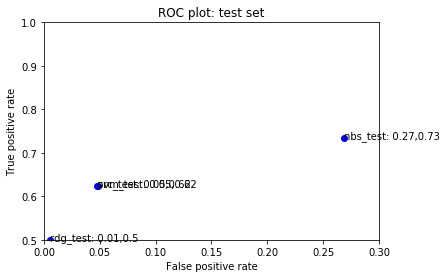

In [159]:
# ROC plot to compare performance of various models and fits

# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
fits = [svm_performance_test,  nbs_performance_test, prc_performance_test, rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'],  fit.desc +': '+str(round(fit.performance_measures['FP'] / fit.performance_measures['Neg']*100)/100) +','+ str(round(fit.performance_measures['TP'] / fit.performance_measures['Pos']*100)/100)  )
# plt.axis([0, 1, 0, 1])
plt.axis([0, 0.3, 0.5, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [161]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../final_data/toxiccomments_test.csv', my_random_seed=33, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 1048576)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  punc_count2  punc_count3  punc_count4  punc_count5  \
0          72          10            0            0            0            0   
1          13           1            0            0            0 

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [162]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
# my_submission["prediction"] = ols.predict(X_test_submission)
my_submission["prediction"] = prc.predict(X_test_submission)

# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.16221174688569115


In [163]:
raw_data.head()

,id,comment_text,word_count,punc_count,punc_count2,punc_count3,punc_count4,punc_count5,punc_count6,punc_count7,punc_count8,punc_count9,punc_count10
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0,0,0,0,0,0,0,368,368
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0,0,0,0,0,0,0,51,51
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0,0,0,0,0,0,0,55,55
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0,0,0,0,0,0,0,206,206
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0,0,0,0,0,0,0,42,42


In [164]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [165]:
my_submission.shape

(153164, 2)

In [167]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('../final_data/toxiccomments_submission_draft1.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation